In [1]:
# General Imports
import math
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Ray Imports
from ray import tune
from ray.tune.registry import register_env
import ray.rllib.agents.ppo as ppo

# TT Imports
import tensortrade.env.default as default
from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange,ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.feed.core import Stream, DataFeed
from tensortrade.oms.instruments import Instrument
from tensortrade.oms.wallets import Portfolio

---

### DRL Model

### Train

Now in order to use our custom environment in ray we must first write a function that creates an instance of the TradingEnv from a configuration dictionary.

In [2]:
def create_training_env(config):
    """Creates Trading Environment. """
    
    # 1. Data and TensorTrade Objects
    # dataset = pd.read_csv('../../data/market/ohlcv_daily_TA/PETR3_train.csv')
    dataset = pd.read_csv('../../data/contextual_data_market_and_text/daily/PETR3_train.csv')
    
    # Price Series
    price = Stream.source(list(dataset["close"]), dtype="float").rename("BRL-ASSETS")
    
    b3_commission = 0.0035
    b3_options = ExchangeOptions(commission=b3_commission)
    b3_exchange = Exchange( name="B3", 
                            service=execute_order, 
                            options=b3_options)(price)
    
    # Instruments
    BRL = Instrument("BRL", 2, "Brazilian Currency")
    ASSETS = Instrument("ASSETS", 2, "Assets")

    # Portfolio
    cash = Wallet(b3_exchange, 100000 * BRL) # Money
    asset = Wallet(b3_exchange, 0 * ASSETS) # Stocks/Assets
    
    portfolio = Portfolio(BRL, [cash, asset])
    
    features = []
    for c in dataset.columns[1:]:
        s = Stream.source(list(dataset[c]), dtype="float").rename(dataset[c].name)
        features += [s]
    print (features)
    feed = DataFeed(features)
    feed.compile()
    
    # 2. Rewards

    # Rewards - Risk Adjusted Returns
    # reward_scheme = default.rewards.RiskAdjustedReturns(
    #     return_algorithm='sharpe',
    #     risk_free_rate=0,
    #     window_size= 7 * 5
    # )
    
    # Rewards - Simple Profit
    reward_scheme = default.rewards.SimpleProfit()
    
    # 3. Actions - Managed Risk Orders
    action_scheme = default.actions.ManagedRiskOrders(
        stop=[0.05],
        take=[0.075],
        min_order_pct=0.5
    )

    # 4. Visualization
    renderer_feed = DataFeed([
        Stream.source(list(dataset['date'])).rename("date"),
        Stream.source(list(dataset["open"]), dtype="float").rename("open"),
        Stream.source(list(dataset["high"]), dtype="float").rename("high"),
        Stream.source(list(dataset["low"]), dtype="float").rename("low"),
        Stream.source(list(dataset["close"]), dtype="float").rename("close"),
        Stream.source(list(dataset["volume"]), dtype="float").rename("volume")
    ])

    # 5. Environment
    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=default.renderers.PlotlyTradingChart(display=True, auto_open_html=False, save_format="png"),
        window_size=config["window_size"],
        max_allowed_loss=0.4
    )
    
    return environment

register_env("TradingEnv", create_training_env)

---

Now that the environment is registered we can run the training algorithm using the Proximal Policy Optimization (PPO) algorithm implemented in rllib.

In [3]:
window_size = 10

env_config_training = {
    # We want to look at the last N samples (days or hours)
    "window_size": window_size, # hours * days
    # And calculate reward based on the actions taken in the next 7 hours
    "reward_window_size": math.ceil(window_size / 2),
    # If it goes past 10% loss during the iteration, we don't want to waste time on a "loser".
    "max_allowed_loss": 0.10,
}

analysis = tune.run(
    run_or_experiment="PPO",
    name="MyExperiment",
    metric="episode_reward_mean",
    mode="max",
    stop={
      "training_iteration": 5
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": window_size
        },
        "log_level": "WARNING",
        "framework": "tf2",
        "eager_tracing": True,
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 1,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0.5,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },

    checkpoint_at_end=True
)

2022-06-07 23:53:24,921	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8265
2022-06-07 23:53:35,255	ERROR syncer.py:111 -- Log sync requires rsync to be installed.
 pid=11928) 2022-06-07 23:53:40,536	INFO trainer.py:712 -- Executing eagerly (framework='tf2'), with eager_tracing=True. For production workloads, make sure to set `eager_tracing=True` in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.


 pid=9404) [<tensortrade.feed.core.base.IterableStream object at 0x00000247042744C0>, <tensortrade.feed.core.base.IterableStream object at 0x0000024704274610>, <tensortrade.feed.core.base.IterableStream object at 0x0000024704274760>, <tensortrade.feed.core.base.IterableStream object at 0x00000247042747C0>, <tensortrade.feed.core.base.IterableStream object at 0x0000024704274910>, <tensortrade.feed.core.base.IterableStream object at 0x0000024704274A60>, <tensortrade.feed.core.base.IterableStream object at 0x0000024704274BB0>, <tensortrade.feed.core.base.IterableStream object at 0x0000024704274D00>, <tensortrade.feed.core.base.IterableStream object at 0x0000024704274E50>, <tensortrade.feed.core.base.IterableStream object at 0x0000024704274FA0>, <tensortrade.feed.core.base.IterableStream object at 0x00000247042C5130>, <tensortrade.feed.core.base.IterableStream object at 0x00000247042C5280>, <tensortrade.feed.core.base.IterableStream object at 0x00000247042C53D0>, <tensortrade.feed.core.bas

Trial name,status,loc
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928


 pid=11928) 2022-06-07 23:53:50,058	INFO trainable.py:124 -- Trainable.setup took 10.363 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 pid=11928) 2022-06-07 23:53:50,059	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Trial name,status,loc
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928


Trial name,status,loc
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928


Trial name,status,loc
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928


Trial name,status,loc
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928


 pid=11928) 2022-06-07 23:54:08,762	WARNING deprecation.py:45 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
 pid=11928) 2022-06-07 23:54:08,763	WARNING deprecation.py:45 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928


Trial name,status,loc
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928


Trial name,status,loc
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928


Result for PPO_TradingEnv_305cb_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-06-07_23-54-24
  done: false
  episode_len_mean: 300.0
  episode_media: {}
  episode_reward_max: 0.26054543706204436
  episode_reward_mean: 0.02792202369375981
  episode_reward_min: -0.21051396095803077
  episodes_this_iter: 13
  episodes_total: 13
  experiment_id: cca9f26a5ef547668e10c15883f8d4e4
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 0.10000000149011612
          entropy: 3.043851137161255
          entropy_coeff: 0.009999999776482582
          kl: 0.000662622565869242
          policy_loss: -0.006938477512449026
          total_loss: 0.41161906719207764
          vf_explained_var: 0.03473706915974617
          vf_loss: 0.8977269530296326
    num_agent_steps_sampled: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_s

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,1,34.6018,4000,0.027922,0.260545,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,1,34.6018,4000,0.027922,0.260545,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,1,34.6018,4000,0.027922,0.260545,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,1,34.6018,4000,0.027922,0.260545,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,1,34.6018,4000,0.027922,0.260545,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,1,34.6018,4000,0.027922,0.260545,-0.210514,300


Result for PPO_TradingEnv_305cb_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-06-07_23-54-52
  done: false
  episode_len_mean: 300.0
  episode_media: {}
  episode_reward_max: 0.26054543706204436
  episode_reward_mean: 0.021286227154515207
  episode_reward_min: -0.21051396095803077
  episodes_this_iter: 13
  episodes_total: 26
  experiment_id: cca9f26a5ef547668e10c15883f8d4e4
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.10000000149011612
          cur_lr: 0.000699999975040555
          entropy: 2.97947096824646
          entropy_coeff: 0.009999999776482582
          kl: 0.06401050090789795
          policy_loss: -0.12015052139759064
          total_loss: -0.016164304688572884
          vf_explained_var: 0.7247273921966553
          vf_loss: 0.2547597289085388
    num_agent_steps_sampled: 8000
    num_steps_sampled: 8000
    num_steps_trained: 8000
    num_steps_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,2,62.1423,8000,0.0212862,0.260545,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,2,62.1423,8000,0.0212862,0.260545,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,2,62.1423,8000,0.0212862,0.260545,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,2,62.1423,8000,0.0212862,0.260545,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,2,62.1423,8000,0.0212862,0.260545,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,2,62.1423,8000,0.0212862,0.260545,-0.210514,300


Result for PPO_TradingEnv_305cb_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-06-07_23-55-22
  done: false
  episode_len_mean: 300.0
  episode_media: {}
  episode_reward_max: 0.3855211087892565
  episode_reward_mean: 0.06429692586976096
  episode_reward_min: -0.21051396095803077
  episodes_this_iter: 14
  episodes_total: 40
  experiment_id: cca9f26a5ef547668e10c15883f8d4e4
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.15000000596046448
          cur_lr: 0.0003000000142492354
          entropy: 2.9105606079101562
          entropy_coeff: 0.009999999776482582
          kl: 0.03647465631365776
          policy_loss: -0.12536907196044922
          total_loss: -0.0607537105679512
          vf_explained_var: 0.8202265501022339
          vf_loss: 0.17649953067302704
    num_agent_steps_sampled: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
    num_st

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,3,92.6843,12000,0.0642969,0.385521,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,3,92.6843,12000,0.0642969,0.385521,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,3,92.6843,12000,0.0642969,0.385521,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,3,92.6843,12000,0.0642969,0.385521,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,3,92.6843,12000,0.0642969,0.385521,-0.210514,300


Result for PPO_TradingEnv_305cb_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-06-07_23-55-51
  done: false
  episode_len_mean: 300.0
  episode_media: {}
  episode_reward_max: 0.3855211087892565
  episode_reward_mean: 0.061375658707561655
  episode_reward_min: -0.21051396095803077
  episodes_this_iter: 13
  episodes_total: 53
  experiment_id: cca9f26a5ef547668e10c15883f8d4e4
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.22499999403953552
          cur_lr: 9.7999996796716e-05
          entropy: 2.871744394302368
          entropy_coeff: 0.009999999776482582
          kl: 0.020567364990711212
          policy_loss: -0.09977366030216217
          total_loss: -0.03128713741898537
          vf_explained_var: 0.8109886050224304
          vf_loss: 0.18515262007713318
    num_agent_steps_sampled: 16000
    num_steps_sampled: 16000
    num_steps_trained: 16000
    num_st

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,4,121.287,16000,0.0613757,0.385521,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,4,121.287,16000,0.0613757,0.385521,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,4,121.287,16000,0.0613757,0.385521,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,4,121.287,16000,0.0613757,0.385521,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,4,121.287,16000,0.0613757,0.385521,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,4,121.287,16000,0.0613757,0.385521,-0.210514,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,RUNNING,127.0.0.1:11928,4,121.287,16000,0.0613757,0.385521,-0.210514,300


Result for PPO_TradingEnv_305cb_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2022-06-07_23-56-24
  done: true
  episode_len_mean: 300.0
  episode_media: {}
  episode_reward_max: 0.3855211087892565
  episode_reward_mean: 0.07440711365153896
  episode_reward_min: -0.21051396095803077
  episodes_this_iter: 13
  episodes_total: 66
  experiment_id: cca9f26a5ef547668e10c15883f8d4e4
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.3375000059604645
          cur_lr: 9.40000027185306e-05
          entropy: 2.8309249877929688
          entropy_coeff: 0.009999999776482582
          kl: 0.019747892394661903
          policy_loss: -0.09856583923101425
          total_loss: -0.031318023800849915
          vf_explained_var: 0.8200640082359314
          vf_loss: 0.17778430879116058
    num_agent_steps_sampled: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
    num_st

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_305cb_00000,TERMINATED,127.0.0.1:11928,5,154.783,20000,0.0744071,0.385521,-0.210514,300


2022-06-07 23:56:27,554	INFO tune.py:626 -- Total run time: 172.52 seconds (171.75 seconds for the tuning loop).


---

After training is complete, we would now like to get access to the agents policy. We can do that by restoring the agent using the following code.

In [4]:
# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean", mode="max"),
    metric="episode_reward_mean"    
)
checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": window_size # We want to look at the last x samples (days)
        },
        "framework": "tf2",
        "eager_tracing": False,
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 1,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0.5,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)

agent.restore(checkpoint_path)

2022-06-07 23:56:27,639	INFO trainer.py:712 -- Executing eagerly (framework='tf2'), with eager_tracing=False. For production workloads, make sure to set `eager_tracing=True` in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
 pid=20396) 2022-06-07 23:56:33,386	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)


 pid=20396) [<tensortrade.feed.core.base.IterableStream object at 0x000002B567397520>, <tensortrade.feed.core.base.IterableStream object at 0x000002B567397670>, <tensortrade.feed.core.base.IterableStream object at 0x000002B5673977C0>, <tensortrade.feed.core.base.IterableStream object at 0x000002B567397820>, <tensortrade.feed.core.base.IterableStream object at 0x000002B567397970>, <tensortrade.feed.core.base.IterableStream object at 0x000002B567397AC0>, <tensortrade.feed.core.base.IterableStream object at 0x000002B567397C10>, <tensortrade.feed.core.base.IterableStream object at 0x000002B567397D60>, <tensortrade.feed.core.base.IterableStream object at 0x000002B567397EB0>, <tensortrade.feed.core.base.IterableStream object at 0x000002B567397F70>, <tensortrade.feed.core.base.IterableStream object at 0x000002B567A26190>, <tensortrade.feed.core.base.IterableStream object at 0x000002B567A262E0>, <tensortrade.feed.core.base.IterableStream object at 0x000002B567A26430>, <tensortrade.feed.core.ba

 pid=20396) 2022-06-07 23:56:33,924	DEBUG rollout_worker.py:1534 -- Creating policy for default_policy
 pid=20396) 2022-06-07 23:56:33,932	DEBUG catalog.py:706 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x000002B567A267C0>: Box([[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 pid=20396)   -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=20396)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 pid=20396)   -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=20396)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 pid=20396)   -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=20396)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 pid=20396)   -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=20396)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 pid=20396)   -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=20396)  [-inf -inf -inf -inf -inf -inf -inf -i

---

After training is complete, we would now like to get access to the agents policy. We can do that by restoring the agent using the following code.

In [5]:
# Restore agent
agent.restore(checkpoint_path)

# Instantiate the environment
env = create_training_env({
    "window_size": window_size
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

2022-06-07 23:56:39,604	INFO trainable.py:467 -- Restored on 127.0.0.1 from checkpoint: C:\Users\mathe\ray_results\MyExperiment\PPO_TradingEnv_305cb_00000_0_2022-06-07_23-53-35\checkpoint_000005\checkpoint-5
2022-06-07 23:56:39,605	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 5, '_timesteps_total': 0, '_time_total': 154.78294253349304, '_episodes_total': 66}


[<tensortrade.feed.core.base.IterableStream object at 0x000001C7191426D0>, <tensortrade.feed.core.base.IterableStream object at 0x000001C71F7F3610>, <tensortrade.feed.core.base.IterableStream object at 0x000001C71F7F3820>, <tensortrade.feed.core.base.IterableStream object at 0x000001C71F7F30D0>, <tensortrade.feed.core.base.IterableStream object at 0x000001C71F7F8F10>, <tensortrade.feed.core.base.IterableStream object at 0x000001C719368430>, <tensortrade.feed.core.base.IterableStream object at 0x000001C719131700>, <tensortrade.feed.core.base.IterableStream object at 0x000001C717F4A550>, <tensortrade.feed.core.base.IterableStream object at 0x000001C724E74B80>, <tensortrade.feed.core.base.IterableStream object at 0x000001C71F8CFF10>, <tensortrade.feed.core.base.IterableStream object at 0x000001C71F8CF640>, <tensortrade.feed.core.base.IterableStream object at 0x000001C71F8CFA60>, <tensortrade.feed.core.base.IterableStream object at 0x000001C71F8CFAF0>, <tensortrade.feed.core.base.IterableS

FigureWidget({
    'data': [{'name': 'Price',
              'showlegend': False,
              'type': 'candle…

---

### Validation Set

In [6]:
def create_eval_env(config):
    """Creates the Evaluation Environment."""
    #dataset = pd.read_csv('../../data/market/ohlcv_daily_TA/PETR3_test.csv')
    dataset = pd.read_csv('../../data/contextual_data_market_and_text/daily/PETR3_test.csv')

    # Price Series
    price = Stream.source(list(dataset["close"]), dtype="float").rename("BRL-ASSETS")
    
    b3_commission = 0.0035
    b3_options = ExchangeOptions(commission=b3_commission)
    b3_exchange = Exchange("B3", service=execute_order, options=b3_options)(price)
    
    # Instruments
    BRL = Instrument("BRL", 2, "Brazilian Currency")
    ASSETS = Instrument("ASSETS", 2, "Assets")

    # Portfolio
    cash = Wallet(b3_exchange, 100000 * BRL) # Money
    asset = Wallet(b3_exchange, 0 * ASSETS) # Stocks/Assets
    
    portfolio = Portfolio(BRL, [cash, asset])
    
    features = []
    for c in dataset.columns[1:]:
        s = Stream.source(list(dataset[c]), dtype="float").rename(dataset[c].name)
        features += [s]
    print (features)
    feed = DataFeed(features)
    feed.compile()
    
    # Rewards - Risk Adjusted Returns
    # reward_scheme = default.rewards.RiskAdjustedReturns(
    #     return_algorithm='sharpe',
    #     risk_free_rate=0,
    #     window_size= 7 * 5
    # )

    # Rewards - Simple Profit
    reward_scheme = default.rewards.SimpleProfit()
    
    # Actions
    action_scheme = default.actions.ManagedRiskOrders(
        stop=[0.05],
        take=[0.075],
        min_order_pct=0.5
    )

    # A discrete action scheme that determines actions based on managing risk
    # action_scheme = default.actions.ManagedRiskOrders()
    
    # Visualization
    renderer_feed = DataFeed([
        Stream.source(list(dataset['date'])).rename("date"),
        Stream.source(list(dataset["open"]), dtype="float").rename("open"),
        Stream.source(list(dataset["high"]), dtype="float").rename("high"),
        Stream.source(list(dataset["low"]), dtype="float").rename("low"),
        Stream.source(list(dataset["close"]), dtype="float").rename("close"),
        Stream.source(list(dataset["volume"]), dtype="float").rename("volume")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=default.renderers.PlotlyTradingChart(display=True, auto_open_html=False, save_format="png"),
        window_size=config["window_size"],
        max_allowed_loss=0.4
    )
    
    return environment, portfolio

In [7]:
# 1. Instantiate the evaluation environment
env, portfolio = create_eval_env({
    "window_size": window_size
})

# 2. Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
    
env.render()

portfolio.ledger.as_frame().head(10)

[<tensortrade.feed.core.base.IterableStream object at 0x000001C920914730>, <tensortrade.feed.core.base.IterableStream object at 0x000001C71F7FB610>, <tensortrade.feed.core.base.IterableStream object at 0x000001C71F7FB3D0>, <tensortrade.feed.core.base.IterableStream object at 0x000001C71F7FBB50>, <tensortrade.feed.core.base.IterableStream object at 0x000001C920C274C0>, <tensortrade.feed.core.base.IterableStream object at 0x000001C920C273A0>, <tensortrade.feed.core.base.IterableStream object at 0x000001C920C27BE0>, <tensortrade.feed.core.base.IterableStream object at 0x000001C920C27AC0>, <tensortrade.feed.core.base.IterableStream object at 0x000001C920C27EE0>, <tensortrade.feed.core.base.IterableStream object at 0x000001C920C27CD0>, <tensortrade.feed.core.base.IterableStream object at 0x000001C920C27F70>, <tensortrade.feed.core.base.IterableStream object at 0x000001C920C27AF0>, <tensortrade.feed.core.base.IterableStream object at 0x000001C920C83130>, <tensortrade.feed.core.base.IterableS

FigureWidget({
    'data': [{'name': 'Price',
              'showlegend': False,
              'type': 'candle…

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,6cd26c2b-e967-4562-be57-c9dac112487c,8,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),50000.00 BRL,50000.00 BRL,50000.00 BRL,50000.00 BRL
1,6cd26c2b-e967-4562-be57-c9dac112487c,8,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),175.00 BRL,50000.00 BRL,49825.00 BRL,49825.00 BRL
2,6cd26c2b-e967-4562-be57-c9dac112487c,8,B3:BRL/locked,B3,WITHDRAWAL (FILL ORDER),49825.00 BRL,50000.00 BRL,0.00 BRL,0.00 BRL
3,6cd26c2b-e967-4562-be57-c9dac112487c,8,B3,B3:ASSETS/locked,DEPOSIT (TRADED 49825.00 BRL B3:BRL/ASSETS @ 2...,2046.20 ASSETS,0.00 ASSETS,2046.20 ASSETS,2046.20 ASSETS
4,6cd26c2b-e967-4562-be57-c9dac112487c,11,B3:ASSETS/locked,B3,WITHDRAWAL (COMMISSION),7.16 ASSETS,0.00 ASSETS,2039.04 ASSETS,2039.04 ASSETS
5,6cd26c2b-e967-4562-be57-c9dac112487c,11,B3:ASSETS/locked,B3,WITHDRAWAL (FILL ORDER),2039.04 ASSETS,0.00 ASSETS,0.00 ASSETS,0.00 ASSETS
6,6cd26c2b-e967-4562-be57-c9dac112487c,11,B3,B3:BRL/locked,DEPOSIT (TRADED 2039.04 ASSETS B3:BRL/ASSETS @...,47081.43 BRL,50000.00 BRL,47081.43 BRL,47081.43 BRL
7,6cd26c2b-e967-4562-be57-c9dac112487c,11,B3:BRL/locked,B3:BRL/free,UNLOCK BRL (COMPLETED),47081.43 BRL,97081.43 BRL,0.00 BRL,0.00 BRL
8,6cd26c2b-e967-4562-be57-c9dac112487c,11,B3:ASSETS/locked,B3:ASSETS/free,UNLOCK ASSETS (COMPLETED),0.00 ASSETS,0.00 ASSETS,0.00 ASSETS,0.00 ASSETS
9,ffb0187b-a0c3-4cbf-947e-ae6ee63f589c,13,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),87373.29 BRL,9708.14 BRL,87373.29 BRL,87373.29 BRL


In [8]:
portfolio.ledger.as_frame().head(10)

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,6cd26c2b-e967-4562-be57-c9dac112487c,8,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),50000.00 BRL,50000.00 BRL,50000.00 BRL,50000.00 BRL
1,6cd26c2b-e967-4562-be57-c9dac112487c,8,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),175.00 BRL,50000.00 BRL,49825.00 BRL,49825.00 BRL
2,6cd26c2b-e967-4562-be57-c9dac112487c,8,B3:BRL/locked,B3,WITHDRAWAL (FILL ORDER),49825.00 BRL,50000.00 BRL,0.00 BRL,0.00 BRL
3,6cd26c2b-e967-4562-be57-c9dac112487c,8,B3,B3:ASSETS/locked,DEPOSIT (TRADED 49825.00 BRL B3:BRL/ASSETS @ 2...,2046.20 ASSETS,0.00 ASSETS,2046.20 ASSETS,2046.20 ASSETS
4,6cd26c2b-e967-4562-be57-c9dac112487c,11,B3:ASSETS/locked,B3,WITHDRAWAL (COMMISSION),7.16 ASSETS,0.00 ASSETS,2039.04 ASSETS,2039.04 ASSETS
5,6cd26c2b-e967-4562-be57-c9dac112487c,11,B3:ASSETS/locked,B3,WITHDRAWAL (FILL ORDER),2039.04 ASSETS,0.00 ASSETS,0.00 ASSETS,0.00 ASSETS
6,6cd26c2b-e967-4562-be57-c9dac112487c,11,B3,B3:BRL/locked,DEPOSIT (TRADED 2039.04 ASSETS B3:BRL/ASSETS @...,47081.43 BRL,50000.00 BRL,47081.43 BRL,47081.43 BRL
7,6cd26c2b-e967-4562-be57-c9dac112487c,11,B3:BRL/locked,B3:BRL/free,UNLOCK BRL (COMPLETED),47081.43 BRL,97081.43 BRL,0.00 BRL,0.00 BRL
8,6cd26c2b-e967-4562-be57-c9dac112487c,11,B3:ASSETS/locked,B3:ASSETS/free,UNLOCK ASSETS (COMPLETED),0.00 ASSETS,0.00 ASSETS,0.00 ASSETS,0.00 ASSETS
9,ffb0187b-a0c3-4cbf-947e-ae6ee63f589c,13,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),87373.29 BRL,9708.14 BRL,87373.29 BRL,87373.29 BRL


In [9]:
df = pd.DataFrame(portfolio.performance)

<AxesSubplot:>

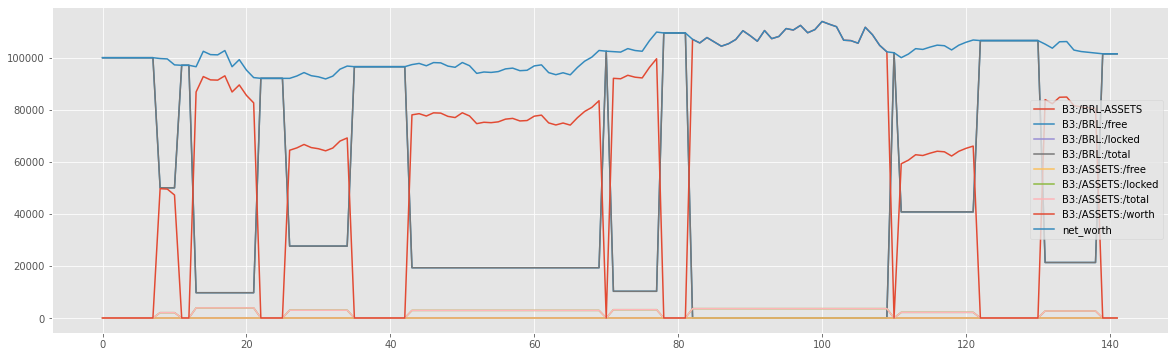

In [10]:
df.T.plot(figsize=(20,6))

<AxesSubplot:>

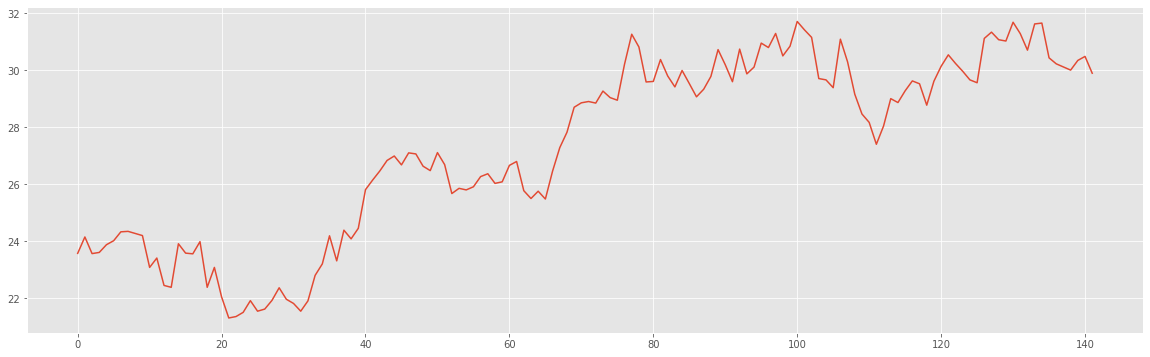

In [11]:
df.loc["B3:/BRL-ASSETS"].plot(figsize=(20,6))

<AxesSubplot:>

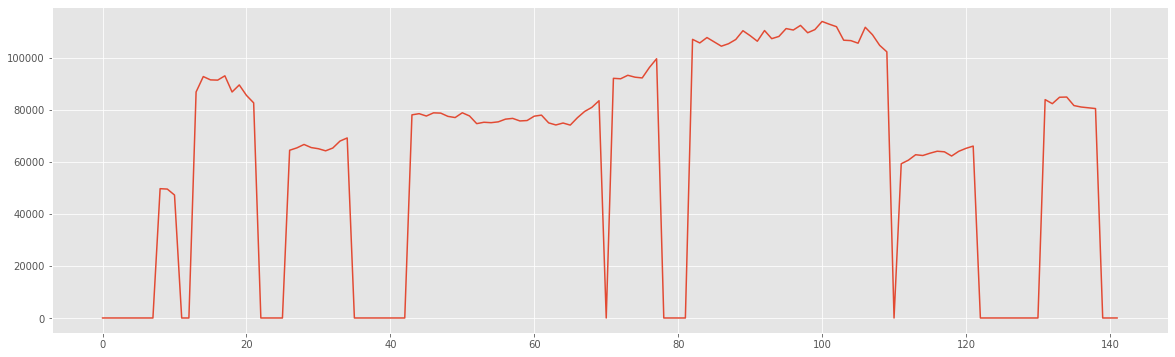

In [12]:
df.loc["B3:/ASSETS:/worth"].plot(figsize=(20,6))

---

### Net Worth Analysis (with Quantstats)

In [13]:
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

In [14]:
#dataset = pd.read_csv('../../data/market/ohlcv_daily_TA/PETR3_test.csv')
dataset = pd.read_csv('../../data/contextual_data_market_and_text/daily/PETR3_test.csv')

net_worth = df.loc["net_worth"].rename('close')
net_worth.index = dataset['date'].loc[:]
net_worth.index = pd.to_datetime(net_worth.index)

net_worth = net_worth.resample('D').last()
net_worth.index = net_worth.index.date
net_worth.index = net_worth.index.rename('date')

In [15]:
net_returns = net_worth.pct_change().dropna()
net_returns.index = pd.to_datetime(net_returns.index)
net_returns

date
2021-10-05    0.000000
2021-10-06    0.000000
2021-10-07    0.000000
2021-10-08    0.000000
2021-10-09    0.000000
                ...   
2022-04-28   -0.002766
2022-04-29    0.000000
2022-04-30    0.000000
2022-05-01    0.000000
2022-05-02    0.000000
Name: close, Length: 210, dtype: float64

In [16]:
# show sharpe ratio
qs.stats.sharpe(net_returns)

0.19128542853729036

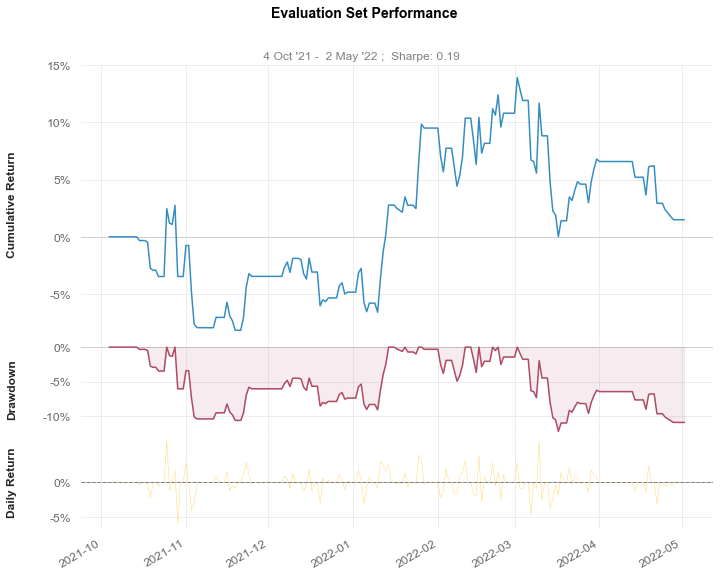

In [17]:
# Show overall performance
qs.plots.snapshot(net_returns, title=f'Evaluation Set Performance')

In [18]:
# Convert datetime to date (keep end of day result)
qs.reports.html(net_returns, "^BVSP")

---